# 9 Improving performance

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Learning curves

In [2]:
from sklearn.datasets import load_digits

In [3]:
digits = load_digits()

In [5]:
X, y = digits.data, digits.target

In [6]:
#digits

In [7]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

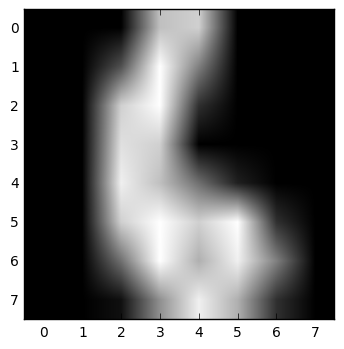

In [15]:
plt.imshow(X.reshape(-1, 8, 8)[6],cmap='gray')

In [16]:
X.shape

(1797, 64)

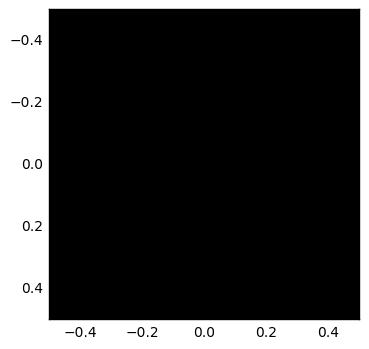

In [37]:
plt.imshow(X.reshape(-1,1,1)[6],cmap='gray')

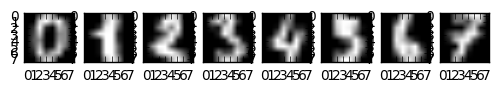

In [38]:
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X.reshape(-1, 8, 8)[i], cmap='gray')

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [40]:
K.clear_session()

In [42]:
model = Sequential()
model.add(Dense(16, input_shape=(64,), activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
Total params: 1,210
Trainable params: 1,210
Non-trainable params: 0
_________________________________________________________________


In [43]:
# store the initial random weights
initial_weights = model.get_weights()

In [44]:
y_cat = to_categorical(y, 10)

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat,
                                                    test_size=0.3)

In [47]:
X_train.shape

(1257, 64)

In [48]:
train_sizes = (len(X_train) * np.linspace(0.1, 0.999, 4)).astype(int)
train_sizes

array([ 125,  502,  879, 1255])

In [49]:
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_frac, _, y_train_frac, _ = \
    train_test_split(X_train, y_train, train_size=train_size)
    
    # at each iteration reset the weights of the model
    # to the initial random weights
    model.set_weights(initial_weights)
    
    h = model.fit(X_train_frac, y_train_frac,
                  verbose=0,
                  epochs=300,
                  callbacks=[EarlyStopping(monitor='loss', patience=1)])

    r = model.evaluate(X_train_frac, y_train_frac, verbose=0)
    train_scores.append(r[-1])
    
    e = model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(e[-1])
    
    print("Done size: ", train_size)

/home/mb45296/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Done size:  125
Done size:  502
Done size:  879
Done size:  1255


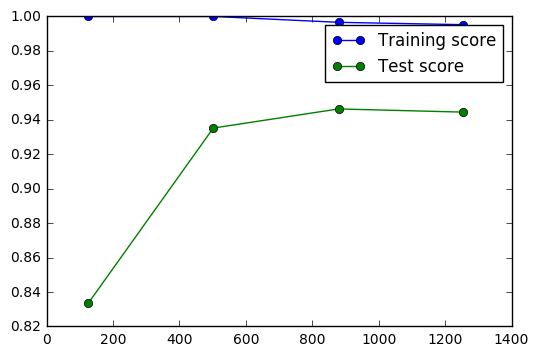

In [50]:
plt.plot(train_sizes, train_scores, 'o-', label="Training score")
plt.plot(train_sizes, test_scores, 'o-', label="Test score")
plt.legend(loc="best")

## Batch Normalization

In [3]:
from keras.layers import BatchNormalization

In [55]:
X_train.shape[1]

64

In [56]:
def repeated_training(X_train,
                      y_train,
                      X_test,
                      y_test,
                      units=512,
                      activation='sigmoid',
                      optimizer='sgd',
                      do_bn=False,
                      epochs=10,
                      repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      verbose=0)
        histories.append([h.history['acc'], h.history['val_acc']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [57]:
mean_acc, std_acc, mean_acc_val, std_acc_val = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=False)

0 1 2 


In [58]:
mean_acc_bn, std_acc_bn, mean_acc_val_bn, std_acc_val_bn = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=True)

0 1 2 


In [59]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

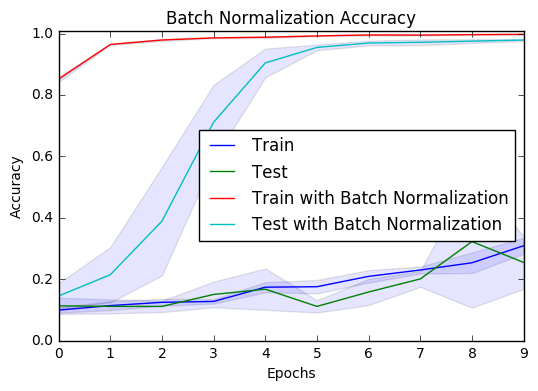

In [60]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_bn, std_acc_bn)
plot_mean_std(mean_acc_val_bn, std_acc_val_bn)
plt.ylim(0, 1.01)
plt.title("Batch Normalization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Batch Normalization', 'Test with Batch Normalization'], loc='best')


## Weight Regularization & Dropout

In [4]:
from keras.layers import Dropout,Flatten

In [62]:
model = Sequential()
model.add(Dropout(0.2, input_shape=X_train.shape[1:]))
# first fully connected layer
model.add(Dense(512, kernel_initializer='normal',
                kernel_regularizer='l2', activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile('sgd',
              'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               33280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 38,410
Trainable params: 38,410
Non-trainable params: 0
_________________________________________________________________


## Data augmentation

In [13]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 20,
                               shear_range = 0.3,
                               zoom_range = 0.3,
                               horizontal_flip = True)

In [64]:
train = generator.flow_from_directory('../data/generator',
                                      target_size = (128, 128),
                                      batch_size = 32,
                                      class_mode = 'binary')

Found 1 images belonging to 1 classes.


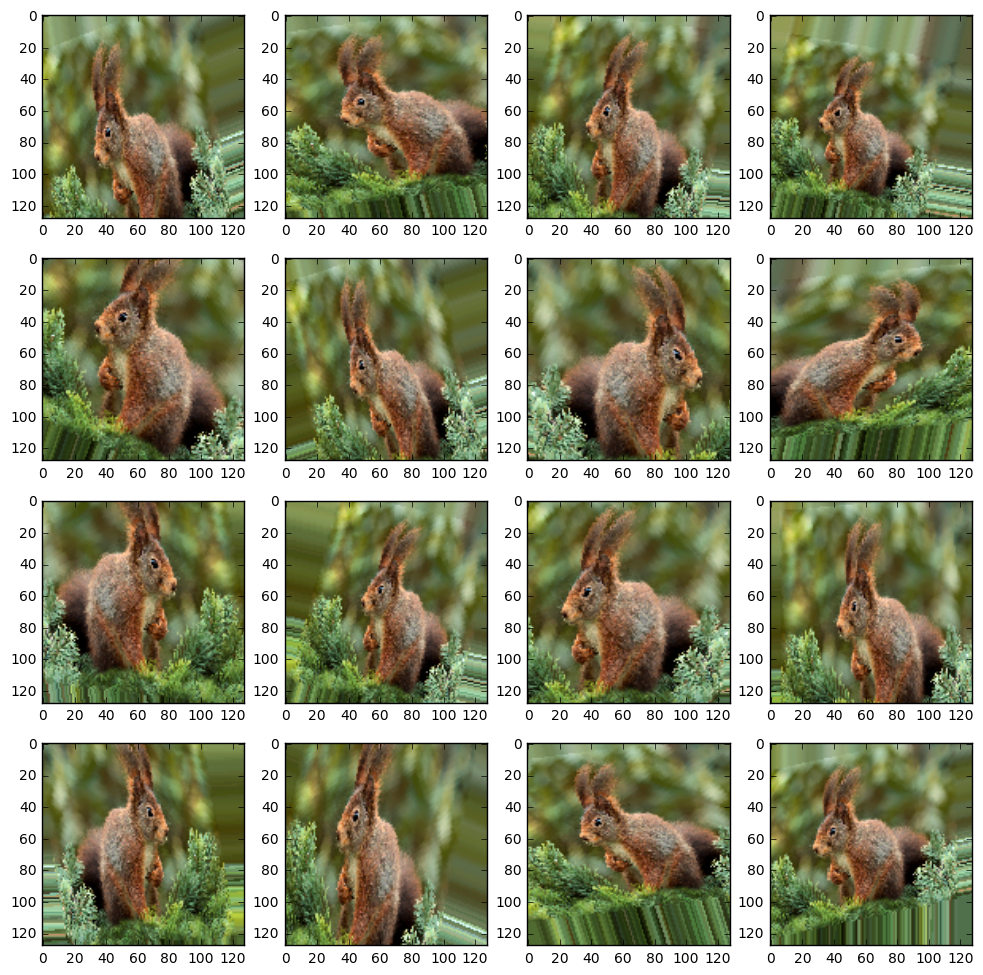

In [65]:
plt.figure(figsize=(12, 12))
for i in range(16):
    img, label = train.next()
    plt.subplot(4, 4, i+1)
    plt.imshow(img[0])

## Embeddings

In [5]:
from keras.layers import Embedding,Activation

In [67]:
model = Sequential()
model.add(Embedding(input_dim=100, output_dim=2))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 2)           200       
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


In [73]:
emb = model.predict_classes(np.array([[81,  1, 96, 79],
                              [17, 47, 69, 50],
                              [49,  3, 12, 88]]))

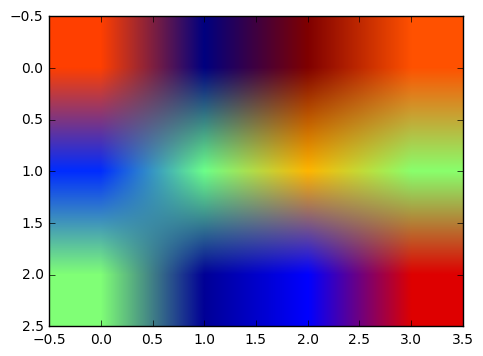

In [72]:
plt.imshow(np.array([[81,  1, 96, 79],
                              [17, 47, 69, 50],
                              [49,  3, 12, 88]]))

In [75]:
emb.shape

(3, 4)

In [74]:
emb

array([[1, 0, 0, 0],
       [0, 1, 0, 1],
       [1, 0, 1, 0]])

## Sentiment prediction on movie Reviews

In [76]:
from keras.datasets import imdb

In [77]:
(X_train, y_train), (X_test, y_test) = imdb.load_data('/tmp/imdb.npz',
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

17465344/17464789 [==============================] - 20s 1us/step


In [78]:
X_train.shape

(25000,)

In [79]:
X_train[1]

[1,
 194,
 1153,
 194,
 8255,
 78,
 228,
 5,
 6,
 1463,
 4369,
 5012,
 134,
 26,
 4,
 715,
 8,
 118,
 1634,
 14,
 394,
 20,
 13,
 119,
 954,
 189,
 102,
 5,
 207,
 110,
 3103,
 21,
 14,
 69,
 188,
 8,
 30,
 23,
 7,
 4,
 249,
 126,
 93,
 4,
 114,
 9,
 2300,
 1523,
 5,
 647,
 4,
 116,
 9,
 35,
 8163,
 4,
 229,
 9,
 340,
 1322,
 4,
 118,
 9,
 4,
 130,
 4901,
 19,
 4,
 1002,
 5,
 89,
 29,
 952,
 46,
 37,
 4,
 455,
 9,
 45,
 43,
 38,
 1543,
 1905,
 398,
 4,
 1649,
 26,
 6853,
 5,
 163,
 11,
 3215,
 10156,
 4,
 1153,
 9,
 194,
 775,
 7,
 8255,
 11596,
 349,
 2637,
 148,
 605,
 15358,
 8003,
 15,
 123,
 125,
 68,
 23141,
 6853,
 15,
 349,
 165,
 4362,
 98,
 5,
 4,
 228,
 9,
 43,
 36893,
 1157,
 15,
 299,
 120,
 5,
 120,
 174,
 11,
 220,
 175,
 136,
 50,
 9,
 4373,
 228,
 8255,
 5,
 25249,
 656,
 245,
 2350,
 5,
 4,
 9837,
 131,
 152,
 491,
 18,
 46151,
 32,
 7464,
 1212,
 14,
 9,
 6,
 371,
 78,
 22,
 625,
 64,
 1382,
 9,
 8,
 168,
 145,
 23,
 4,
 1690,
 15,
 16,
 4,
 1355,
 5,
 28,
 6,
 52,
 

In [80]:
idx = imdb.get_word_index()

1646592/1641221 [==============================] - 3s 2us/step


In [81]:
max(idx.values())

88584

In [82]:
idx

{"babe's": 39059,
 'soros': 76972,
 "kurosawa's": 11535,
 'unacted': 84786,
 'incision': 77574,
 '60th': 47816,
 "may's": 14128,
 'jaipur': 46082,
 'bo': 3278,
 "flunky's": 53395,
 'mistiness': 64542,
 'phillipa': 82966,
 'claudette': 22379,
 'bodysuit': 49166,
 'multy': 82439,
 "goldblum's": 24350,
 "grandparent's": 49462,
 'smiles': 5849,
 'actionless': 65938,
 'surveying': 37899,
 'hid': 14121,
 'eidos': 37289,
 'permaybe': 73436,
 'transformed': 5841,
 'email': 9490,
 'frippery': 77740,
 "webster's": 39812,
 'crude': 2622,
 'buoyed': 31207,
 'successfully': 2973,
 'uniform': 6333,
 'sargeant': 28733,
 'saucy': 17652,
 'carry': 1668,
 "2''": 41220,
 "kinski's": 87555,
 'obscenely': 22030,
 "steiger's": 49948,
 "kirby'll": 64780,
 'presiding': 43661,
 'briliant': 72813,
 'nekhron': 47446,
 'yubb': 69691,
 'vidhu': 69649,
 'mclaughlin': 34505,
 'compounded': 20529,
 'bacri': 81636,
 'shagging': 28753,
 'unatmospherically': 70334,
 'assent': 76967,
 'aris': 76627,
 'unratable': 63483,


In [83]:
rev_idx = {v+3:k for k,v in idx.items()}

In [84]:
rev_idx

{4: 'the',
 5: 'and',
 6: 'a',
 7: 'of',
 8: 'to',
 9: 'is',
 10: 'br',
 11: 'in',
 12: 'it',
 13: 'i',
 14: 'this',
 15: 'that',
 16: 'was',
 17: 'as',
 18: 'for',
 19: 'with',
 20: 'movie',
 21: 'but',
 22: 'film',
 23: 'on',
 24: 'not',
 25: 'you',
 26: 'are',
 27: 'his',
 28: 'have',
 29: 'he',
 30: 'be',
 31: 'one',
 32: 'all',
 33: 'at',
 34: 'by',
 35: 'an',
 36: 'they',
 37: 'who',
 38: 'so',
 39: 'from',
 40: 'like',
 41: 'her',
 42: 'or',
 43: 'just',
 44: 'about',
 45: "it's",
 46: 'out',
 47: 'has',
 48: 'if',
 49: 'some',
 50: 'there',
 51: 'what',
 52: 'good',
 53: 'more',
 54: 'when',
 55: 'very',
 56: 'up',
 57: 'no',
 58: 'time',
 59: 'she',
 60: 'even',
 61: 'my',
 62: 'would',
 63: 'which',
 64: 'only',
 65: 'story',
 66: 'really',
 67: 'see',
 68: 'their',
 69: 'had',
 70: 'can',
 71: 'were',
 72: 'me',
 73: 'well',
 74: 'than',
 75: 'we',
 76: 'much',
 77: 'been',
 78: 'bad',
 79: 'get',
 80: 'will',
 81: 'do',
 82: 'also',
 83: 'into',
 84: 'people',
 85: 'other',

In [85]:
rev_idx[0] = 'padding_char'
rev_idx[1] = 'start_char'
rev_idx[2] = 'oov_char'
rev_idx[3] = 'unk_char'

In [86]:
rev_idx[3]

'unk_char'

In [87]:
y_train[0]

1

In [88]:
example_review = ' '.join([rev_idx[word] for word in X_train[0]])
example_review

"start_char this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and

In [89]:
len(X_train[0])

218

In [90]:
len(X_train[1])

189

In [91]:
len(X_train[2])

141

In [92]:
len(X_train[3])

550

In [93]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM

In [94]:
maxlen = 100

X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

In [95]:
X_train_pad.shape

(25000, 100)

In [96]:
X_train_pad[0]

array([ 1415,    33,     6,    22,    12,   215,    28,    77,    52,
           5,    14,   407,    16,    82, 10311,     8,     4,   107,
         117,  5952,    15,   256,     4, 31050,     7,  3766,     5,
         723,    36,    71,    43,   530,   476,    26,   400,   317,
          46,     7,     4, 12118,  1029,    13,   104,    88,     4,
         381,    15,   297,    98,    32,  2071,    56,    26,   141,
           6,   194,  7486,    18,     4,   226,    22,    21,   134,
         476,    26,   480,     5,   144,    30,  5535,    18,    51,
          36,    28,   224,    92,    25,   104,     4,   226,    65,
          16,    38,  1334,    88,    12,    16,   283,     5,    16,
        4472,   113,   103,    32,    15,    16,  5345,    19,   178,
          32], dtype=int32)

In [100]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

In [101]:
max_features = max([max(x) for x in X_train_pad] + 
                   [max(x) for x in X_test_pad]) + 1
max_features

88587

In [102]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

In [103]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         11339136  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 11,388,609
Trainable params: 11,388,609
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3)

Train on 17500 samples, validate on 7500 samples
Epoch 1/2
17500/17500 [==============================] - 174s 10ms/step - loss: 0.4794 - acc: 0.7661 - val_loss: 0.4172 - val_acc: 0.8167
Epoch 2/2
17500/17500 [==============================] - 165s 9ms/step - loss: 0.2683 - acc: 0.8953 - val_loss: 0.3992 - val_acc: 0.8391


In [105]:
score, acc = model.evaluate(X_test_pad, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 26s 1ms/step
Test score: 0.41090183761596677
Test accuracy: 0.83296


## Exercise 1

- Reload the IMDB data keeping only the first 20000 most common words
- pad the reviews to a shorter length (eg. 70 or 80), this time make sure you keep the first part of the review if it's longer than the maximum length
- re run the model (remember to set max_features correctly)
- does it train faster this time?
- do you get a better performance?

In [250]:
from keras.datasets import imdb
from keras.callbacks import TensorBoard

(X_train, y_train), (X_test, y_test) = imdb.load_data('/tmp/imdb.npz',
                                                      num_words=20000,
                                                      skip_top=200,
                                                      maxlen=None,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [230]:
X_train.shape

(25000,)

In [244]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM

maxlen = 80

X_train_pad = pad_sequences(X_train, maxlen=maxlen,truncating='post')
X_test_pad = pad_sequences(X_test, maxlen=maxlen,truncating='post')

In [245]:
X_train_pad[0]

array([   2,    2,    2,    2,    2,  530,  973, 1622, 1385,    2,  458,
       4468,    2, 3941,    2,    2,    2,  256,    2,    2,    2,    2,
        838,    2,    2,  670,    2,    2,    2,  480,  284,    2,    2,
          2,    2,    2,    2,    2,  336,  385,    2,    2,    2, 4536,
       1111,    2,  546,    2,    2,  447,    2,    2,    2,    2,    2,
          2, 2025,    2,    2,    2,    2, 1920, 4613,  469,    2,    2,
          2,    2,    2,    2,    2,  530,    2,    2,    2,    2, 1247,
          2,    2,    2], dtype=int32)

In [246]:
max_features = max([max(x) for x in X_train_pad] + 
                   [max(x) for x in X_test_pad]) + 1
max_features

20000

In [247]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 2,609,473
Trainable params: 2,609,473
Non-trainable params: 0
_________________________________________________________________


In [252]:
log_dir = './'

model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3,callbacks = [TensorBoard(log_dir = log_dir,
histogram_freq = 50)])

Train on 17500 samples, validate on 7500 samples
Epoch 1/2
17500/17500 [==============================] - 112s 6ms/step - loss: 0.2789 - acc: 0.8919 - val_loss: 0.4988 - val_acc: 0.7859
Epoch 2/2
17500/17500 [==============================] - 83s 5ms/step - loss: 0.1890 - acc: 0.9318 - val_loss: 0.6239 - val_acc: 0.7813


In [253]:
score, acc = model.evaluate(X_test_pad, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 19s 770us/step
Test score: 0.7402911705589295
Test accuracy: 0.74044


## Exercise 2

- Reload the digits data as above
- define a function repeated_training_reg_dropout that adds regularization and dropout to a fully connected network
- compare the performance with/witouth dropout and regularization like we did for batch normalization
- do you get a better performance?

In [194]:
from sklearn.datasets import load_digits

In [195]:
digits=load_digits()

In [196]:
X, y = digits.data, digits.target

In [200]:
from sklearn.model_selection import train_test_split
y_cat = to_categorical(y, 10)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat,
                                                    test_size=0.3)

In [217]:
def repeated_training_reg_dropout (X_train,y_train,X_test,y_test,units=512,activation='sigmoid',optimizer='sgd',do_bn=False,
                      rate=.2,            
                      epochs=10,
                      repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
           # model.add(BatchNormalization())
            model.add(Dropout(rate))

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            #model.add(BatchNormalization())
            model.add(Dropout(rate))

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            #model.add(BatchNormalization())
            model.add(Dropout(rate))

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      verbose=0)
        histories.append([h.history['acc'], h.history['val_acc']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [218]:
mean_acc, std_acc, mean_acc_val, std_acc_val = \
    repeated_training_reg_dropout(X_train, y_train, X_test, y_test, do_bn=False)

0 1 2 


In [219]:
mean_acc_bn, std_acc_bn, mean_acc_val_bn, std_acc_val_bn = \
    repeated_training_reg_dropout(X_train, y_train, X_test, y_test, do_bn=True)

0 1 2 


In [220]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

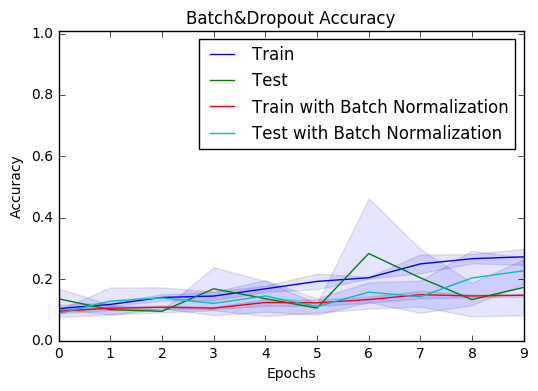

In [221]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_bn, std_acc_bn)
plot_mean_std(mean_acc_val_bn, std_acc_val_bn)
plt.ylim(0, 1.01)
plt.title("Batch&Dropout Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Batch Normalization', 'Test with Batch Normalization'], loc='best')

In [197]:
K.clear_session()
model = Sequential()
model.add(Dense(16, input_shape=(64,), activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 1,210
Trainable params: 1,210
Non-trainable params: 0
_________________________________________________________________


## Exercise 3

This is a very long and complex exercise, that should give you an idea of a real world scenario. Feel free to look at the solution if you feel lost. Also, feel free to run this on Floyd with a GPU, in which case you don't need to download the data.

If you are running this locally, download and unpack the male/female pictures from [here](https://www.dropbox.com/s/nov493om2jmh2gp/male_female.tgz?dl=0). These images and labels were obtained from [Crowdflower](https://www.crowdflower.com/data-for-everyone/).

Your goal is to build an image classifier that will recognize the gender of a person from pictures.

- Have a look at the directory structure and inspect a couple of pictures
- Design a model that will take a color image of size 64x64 as input and return a binary output (female=0/male=1)
- Feel free to introduce any regularization technique in your model (Dropout, Batch Normalization, Weight Regularization)
- Compile your model with an optimizer of your choice
- Using `ImageDataGenerator`, define a train generator that will augment your images with some geometric transformations. Feel free to choose the parameters that make sense to you.
- Define also a test generator, whose only purpose is to rescale the pixels by 1./255
- use the function `flow_from_directory` to generate batches from the train and test folders. Make sure you set the `target_size` to 64x64.
- Use the `model.fit_generator` function to fit the model on the batches generated from the ImageDataGenerator. Since you are streaming and augmenting the data in real time you will have to decide how many batches make an epoch and how many epochs you want to run
- Train your model (you should get to at least 85% accuracy)
- Once you are satisfied with your training, check a few of the misclassified pictures. Are those sensible errors?

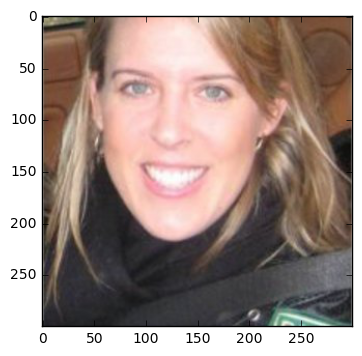

In [8]:
a=plt.imread('../datax/train/0_female/105-large.jpg')
plt.imshow(a)

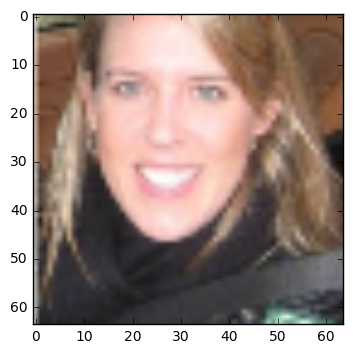

In [6]:
from PIL import Image
from keras.callbacks import TensorBoard

im1 = Image.open('../datax/train/0_female/105-large.jpg')
plt.imshow(im1.resize((64,64),Image.NEAREST))

In [9]:
a.shape

(300, 300, 3)

In [10]:
64*64*3

12288

In [11]:
from keras.layers import Activation,Conv2D,MaxPooling2D,Flatten

model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())          

model.add(Flatten())
model.add(Dense(128,activation='relu'))          
model.add(Dense(1, activation='sigmoid'))

model.compile('adam',
              'binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 29, 29, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
__________

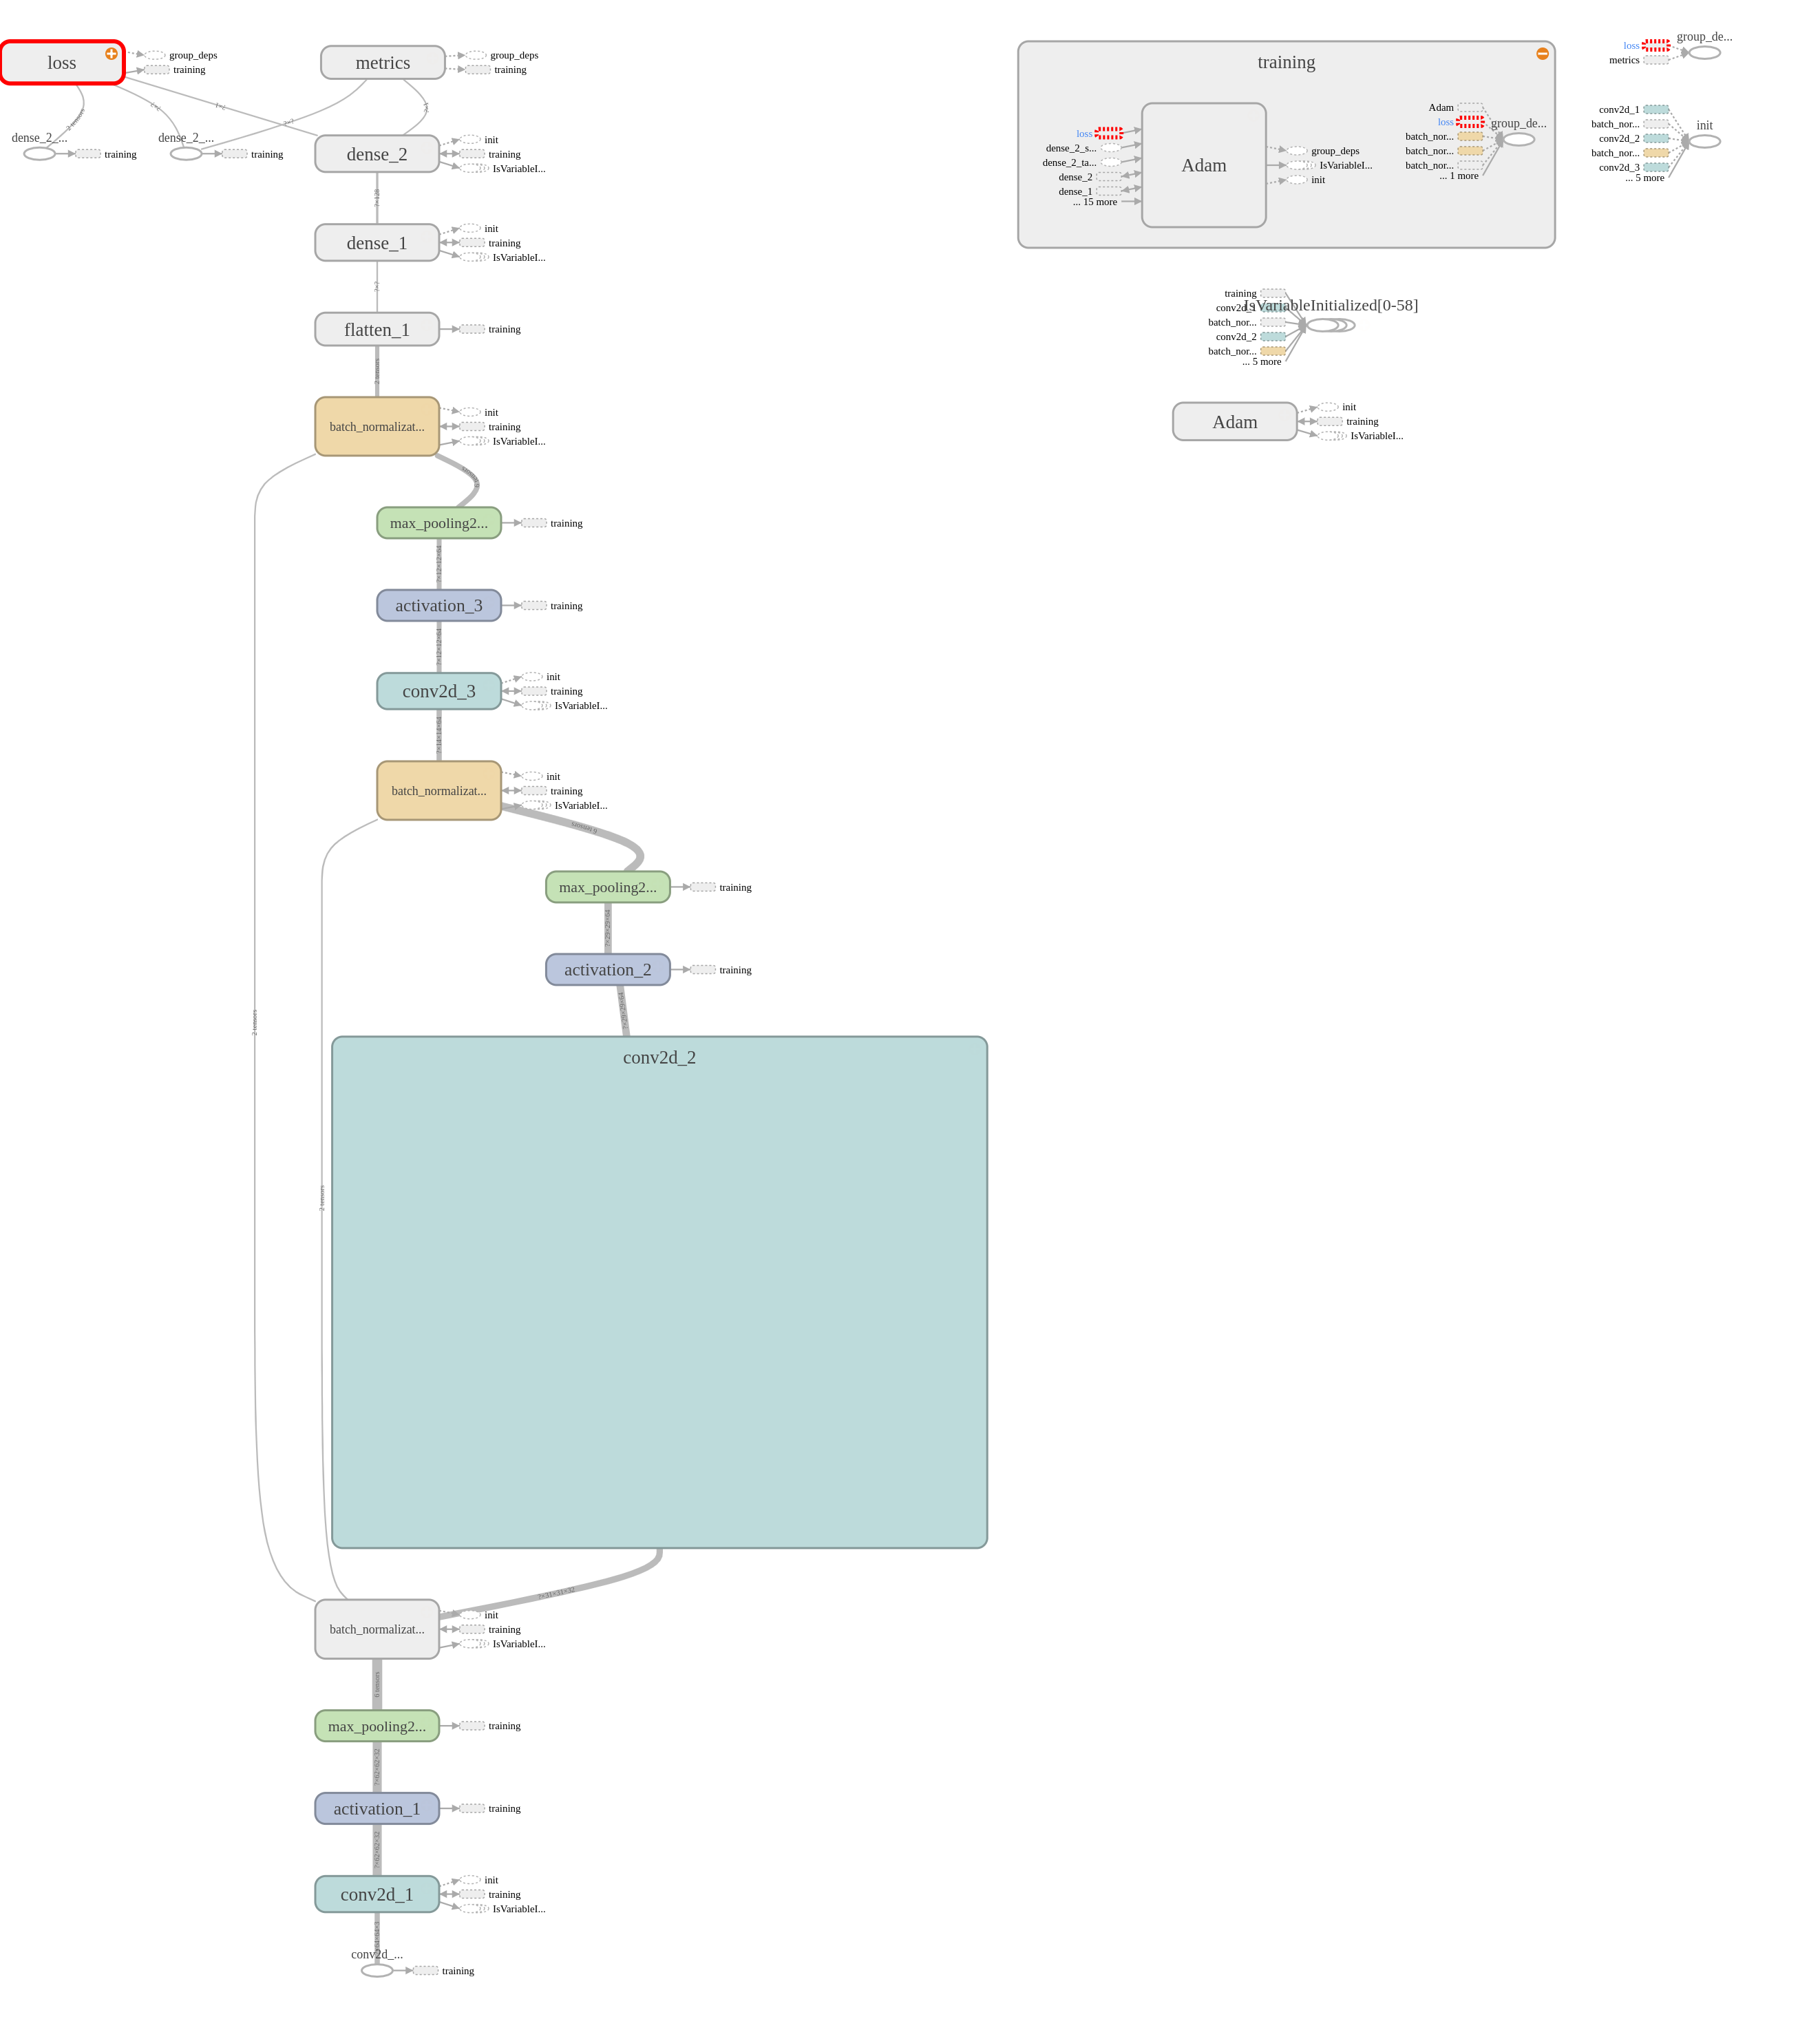

In [19]:
#im=plt.imread('graph_run=.png')
#plt.imshow(im)
from IPython.display import Image
#from IPython.core.display import HTML 
Image('graph_run=.png')

In [14]:
train_generator = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 20,
                               shear_range = 0.3,
                               zoom_range = 0.3,
                               horizontal_flip = True)
test_gen=ImageDataGenerator(rescale = 1./255)

In [15]:
train = train_generator.flow_from_directory('../datax/train',
                                      target_size = (64, 64),
                                      batch_size = 16,
                                      class_mode = 'binary')
test = test_gen.flow_from_directory('../datax/test',
                                     target_size = (64, 64),
                                      batch_size = 16,
                                      class_mode = 'binary')

Found 11663 images belonging to 2 classes.
Found 2920 images belonging to 2 classes.


In [95]:
#plt.figure(figsize=(12, 12))
for i in range(3):
    img, label = train.next()
    #plt.subplot(4, 4, i+1)
    #plt.imshow(img[0])

In [122]:
#plt.figure(figsize=(12, 12))
for i in range(3):
    imgt, labelt = test.next()
    #plt.subplot(4, 4, i+1)
    #plt.imshow(img[0])

0.0


1000

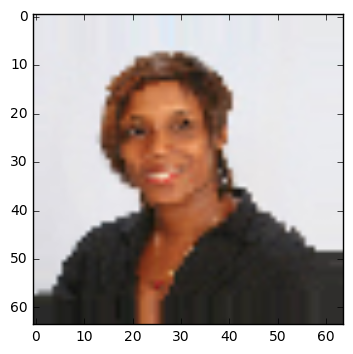

In [118]:
i=456
plt.imshow(img[i])
print(label[i])
len(img)

In [126]:
#model.fit_generator(train,test)

In [17]:
model.fit_generator(train,
                    steps_per_epoch = 800,
                    epochs = 10,
                    validation_data = test,
                    validation_steps = 200,callbacks = [TensorBoard(log_dir = './')])

Epoch 1/10
800/800 [==============================] - 177s 221ms/step - loss: 0.5381 - acc: 0.7175 - val_loss: 0.4893 - val_acc: 0.7491
Epoch 2/10
800/800 [==============================] - 186s 232ms/step - loss: 0.5013 - acc: 0.7485 - val_loss: 0.4807 - val_acc: 0.7560
Epoch 3/10
800/800 [==============================] - 182s 227ms/step - loss: 0.4786 - acc: 0.7614 - val_loss: 0.4546 - val_acc: 0.7744
Epoch 4/10
800/800 [==============================] - 172s 215ms/step - loss: 0.4514 - acc: 0.7764 - val_loss: 0.4021 - val_acc: 0.8048
Epoch 5/10
800/800 [==============================] - 170s 212ms/step - loss: 0.4338 - acc: 0.7932 - val_loss: 0.4515 - val_acc: 0.7929
Epoch 6/10
800/800 [==============================] - 169s 212ms/step - loss: 0.4212 - acc: 0.7975 - val_loss: 0.4115 - val_acc: 0.7942
Epoch 7/10
800/800 [==============================] - 169s 212ms/step - loss: 0.4020 - acc: 0.8061 - val_loss: 0.3932 - val_acc: 0.8055
Epoch 8/10
800/800 [============================

In [163]:
from itertools import islice
islice(test, 50)

In [165]:
X_test = []
y_test = []
for ts in islice(test, 50):
    X_test.append(ts[0])
    y_test.append(ts[1])

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [169]:
len(X_test)

800

In [185]:
y_pred = model.predict_classes(X_test).ravel()

In [182]:
print(model.predict_classes(X_test[0:20]).ravel(),model.predict(X_test[0:20]).ravel())

[1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1] [9.4797319e-01 9.6149153e-01 6.8457878e-01 9.9977225e-01 9.9907100e-01
 9.8678744e-01 9.3552935e-01 7.1392411e-01 6.2046540e-01 9.9518174e-01
 3.2158098e-01 9.9999738e-01 1.1204421e-01 9.9349362e-01 8.1898344e-01
 7.0508718e-01 9.8178631e-01 5.0282255e-05 9.9997962e-01 9.9759811e-01]


In [186]:
np.argwhere(y_test != y_pred).ravel()

array([  0,   1,   2,  21,  23,  27,  32,  35,  36,  37,  46,  50,  60,
        61,  66,  68,  71,  73,  74,  87,  95,  96, 101, 108, 111, 112,
       118, 154, 155, 158, 162, 163, 168, 171, 172, 202, 203, 205, 208,
       216, 220, 233, 238, 240, 249, 252, 255, 260, 262, 267, 282, 307,
       308, 310, 317, 318, 326, 330, 337, 356, 364, 366, 384, 393, 396,
       406, 407, 419, 425, 428, 439, 453, 457, 460, 463, 465, 474, 478,
       485, 500, 502, 505, 509, 510, 522, 532, 539, 543, 549, 552, 560,
       569, 577, 578, 591, 600, 614, 617, 624, 625, 630, 647, 648, 653,
       667, 680, 681, 683, 686, 696, 698, 704, 707, 712, 715, 719, 724,
       728, 737, 739, 741, 745, 746, 751, 765, 767, 768, 771, 779, 781,
       783, 791, 793])

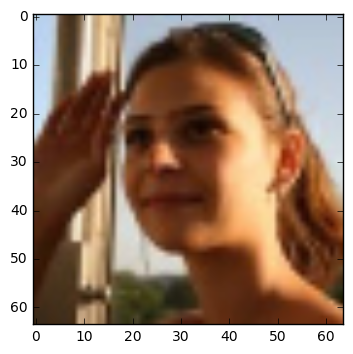

In [187]:
plt.imshow(X_test[50])

In [192]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score 
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.79      0.83       395
         1.0       0.81      0.87      0.84       405

   micro avg       0.83      0.83      0.83       800
   macro avg       0.84      0.83      0.83       800
weighted avg       0.84      0.83      0.83       800

[[314  81]
 [ 52 353]]
0.83375


In [191]:
len(np.argwhere(y_test != y_pred).ravel())-(52+81)

0

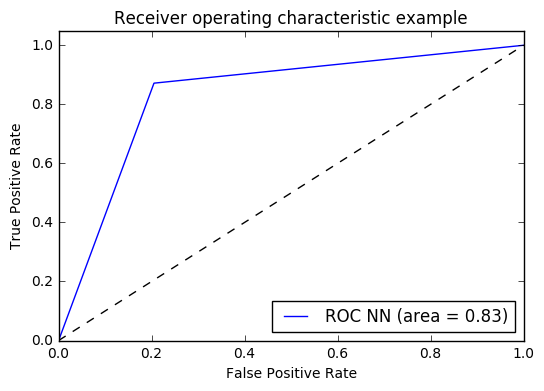

In [193]:
from sklearn.metrics import roc_auc_score, auc,precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
fprk, tprk, thresholds=roc_curve(y_test,y_pred)
nn_auc=auc(fprk,tprk)
from sklearn.metrics import roc_curve, auc
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fprk, tprk, label='ROC NN (area = %0.2f)' % nn_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()